# GNSS-only localization using WLS

Here I demonstrate how to improve the position estimation from the original baseline provided by Kaggle Team. 
Before going into the code, I would like to thank [@YangLiu](https://www.kaggle.com/foreveryoung) for [the great notebook[1]](https://www.kaggle.com/foreveryoung/least-squares-solution-from-gnss-derived-data)! Also, I am new to GNSS field, so feel free to let me know if you find any mistakes in the notebook.

The major problem in GNSS is a multi-path problem.
As most of the competitors would observed, WLS solution from raw GNSS in city areas such as 2021-04-XX-US-SJC-Y are significantly worse compared to other areas. This noise is mainly due to the satellite signals reflected by the surrounding buildings. Since WLS algorithm calculate the optimal position based on the (pseudo-)range between the GNSS receiver and the satellites, this reflection can have a large impact on the estimation accuracy.

To mitigate the adverse effects of this multi-path phenomena, I introduced the following techniques in the estimation algorithm.
1. cauchy loss in least-square optimization (instead of linear loss)
2. elevation mask

The score was **LB: 8.179** before introducing these two algorithms. By adopting these techniques, the score improved to **LB: 6.776**. By ensembling with the provided baseline, the score further improved to **LB: 6.665**.

## 1. cauchy loss in least-square optimization
Cauchy loss is a function defined as
    rho(z) = ln(1 + z)
. This function can weaken the effect of outliers in least-square optimization.

## 2. elevation mask
Elevation mask is a frequently used filtering in GNSS-based localization based on elevation angle (= angle from the GNSS receiver to the satellite with respect to the ground surface). The idea here is very simple: the filter masks out a signal from which the satellite is close to the ground from the GNSS receiver perspective. In other words, the algorithm ignores the satellite signal if the elevation angle of the satellite is close to 0.

In this notebook, I increased the uncertainty of pseudorange of the low-angle satellites instead of ignoring them (for some reason, I found it is more effective through some experiments).

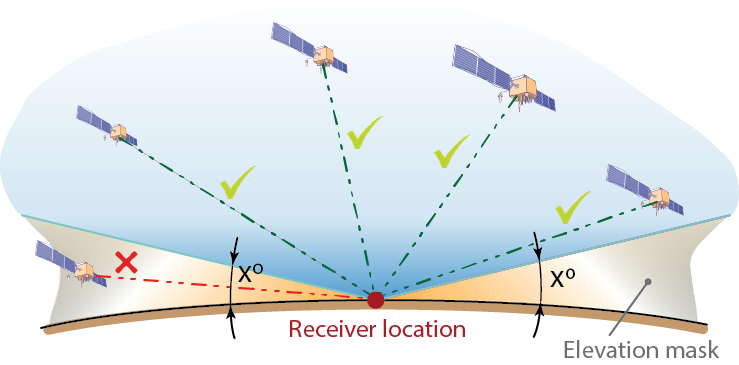


## What did not work
I spent some time investigating RTKLIB. The software incorporates elevation mask as well as plenty of other algorithms (SNR-mask, Real-time kineamtics, etc). I thought that RTK can further improve the estimation, but the results were worse than that of this notebook.


In [ ]:
import numpy as np 
import pandas as pd 
import scipy.optimize as opt
import math
from pathlib import Path
from tqdm.notebook import tqdm
import pyproj
import matplotlib.pyplot as plt
from scipy import stats
import plotly.express as px
import copy
import plotly.graph_objects as go
import json
import pickle

In [ ]:
with open('../input/region-classification/region_type_train.json') as f:
    region_type_train = json.load(f)
with open('../input/region-classification/region_type_test.json') as f:
    region_type_test = json.load(f)

In [ ]:
def visualize_trafic(df, center={"lat":37.423576, "lon":-122.094132}, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=400,
                            width=600)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df, collection, center={"lat":37.423576, "lon":-122.094132}):
    df_traj = df[df['collectionName'] == collection]
    center = {"lat":37.423576, "lon":-122.094132}
    visualize_trafic(df_traj, center)

In [ ]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
          np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

def get_train_score(df, gt):
    gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
    df = df.merge(gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95])
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

def eval_all(df_pred, df_gt):
    scores = []
    compared_cols = ["latDeg_truth","lngDeg_truth","latDeg_pred","lngDeg_pred"]
    collections = sorted(df_gt['collectionName'].unique())
    for collection in collections:
        df_pred_col = df_pred[df_pred['collectionName'] == collection]
        df_gt_col = df_gt[df_gt['collectionName'] == collection]
        
        score = get_train_score(df_pred_col, df_gt_col)
        
        df_merged = pd.merge_asof(df_gt_col.sort_values('millisSinceGpsEpoch'), df_pred_col.sort_values('millisSinceGpsEpoch'), 
                                  on="millisSinceGpsEpoch", by=["collectionName", "phoneName"], 
                                  direction='nearest',tolerance=100000, suffixes=('_truth', '_pred'))
        df_merged = df_merged.sort_values(by=["collectionName", "phoneName", "millisSinceGpsEpoch"], ignore_index=True)

        haversine = calc_haversine(*df_merged[compared_cols].to_numpy().transpose()).mean()
        scores.append([collection, haversine, score])
        
    score = get_train_score(df_pred, df_gt)
    df_merged = pd.merge_asof(df_gt.sort_values('millisSinceGpsEpoch'), df_pred.sort_values('millisSinceGpsEpoch'), 
                              on="millisSinceGpsEpoch", by=["collectionName", "phoneName"], 
                              direction='nearest',tolerance=100000, suffixes=('_truth', '_pred'))
    haversine = calc_haversine(*df_merged[compared_cols].to_numpy().transpose()).mean()
    scores.append(['all', haversine, score])
    
    df_scores = pd.DataFrame(scores, columns=['collection', 'haversine', 'score'])
    return df_scores

In [ ]:
def ecef2lla(x, y, z):
    # x, y and z are scalars or vectors in meters
    x = np.array([x]).reshape(np.array([x]).shape[-1], 1)
    y = np.array([y]).reshape(np.array([y]).shape[-1], 1)
    z = np.array([z]).reshape(np.array([z]).shape[-1], 1)

    a=6378137
    a_sq=a**2
    e = 8.181919084261345e-2
    e_sq = 6.69437999014e-3

    f = 1/298.257223563
    b = a*(1-f)

    # calculations:
    r = np.sqrt(x**2 + y**2)
    ep_sq  = (a**2-b**2)/b**2
    ee = (a**2-b**2)
    f = (54*b**2)*(z**2)
    g = r**2 + (1 - e_sq)*(z**2) - e_sq*ee*2
    c = (e_sq**2)*f*r**2/(g**3)
    s = (1 + c + np.sqrt(c**2 + 2*c))**(1/3.)
    p = f/(3.*(g**2)*(s + (1./s) + 1)**2)
    q = np.sqrt(1 + 2*p*e_sq**2)
    r_0 = -(p*e_sq*r)/(1+q) + np.sqrt(0.5*(a**2)*(1+(1./q)) - p*(z**2)*(1-e_sq)/(q*(1+q)) - 0.5*p*(r**2))
    u = np.sqrt((r - e_sq*r_0)**2 + z**2)
    v = np.sqrt((r - e_sq*r_0)**2 + (1 - e_sq)*z**2)
    z_0 = (b**2)*z/(a*v)
    h = u*(1 - b**2/(a*v))
    phi = np.arctan((z + ep_sq*z_0)/r)
    lambd = np.arctan2(y, x)

    return phi*180/np.pi, lambd*180/np.pi, h

In [ ]:

EARTH_ROTATION_RATE = 7.2921151467e-005
SPEED_OF_LIGHT = 2.99792458e8
EARTH_RADIUS = 6_371_000

def calc_pos_fix(sat_pos, pr, weights=1, x0=[-2.69456739e+06, -4.29648247e+06,  3.85481182e+06, 0], loss='cauchy'):
    '''
    Calculates gps fix with WLS optimizer
    returns:
    0 -> list with positions
    1 -> pseudorange errs
    '''
    n = len(pr)
    if n < 3:
        return x0, []
    Fx_pos = pr_residual(sat_pos, pr, weights=weights)
    opt_pos = opt.least_squares(Fx_pos, x0, loss=loss).x
    return opt_pos, Fx_pos(opt_pos, weights=1)

def pr_residual(sat_pos, pr, weights=1):
    # solve for pos
    def Fx_pos(x_hat, weights=weights):
        theta = EARTH_ROTATION_RATE * (pr - x_hat[3]) / SPEED_OF_LIGHT
        # theta = EARTH_ROTATION_RATE * (pr) / SPEED_OF_LIGHT
        dx = np.sqrt(
            (sat_pos[:, 0] * np.cos(theta) + sat_pos[:, 1] * np.sin(theta) - x_hat[0])**2 + 
            (-sat_pos[:, 0] * np.sin(theta) + sat_pos[:, 1] * np.cos(theta) - x_hat[1])**2 +
            (sat_pos[:, 2] - x_hat[2]) ** 2
        )
        rows = weights * (dx - pr + x_hat[3])
        return rows
    return Fx_pos

In [ ]:
def estimation_pipeline(df_trails, region_type, eldeg_high = 50, eldeg_mid = 25, eldeg_low = 15):
    """ simple pipeline to estimate the GNSS receiver location by least square
    Args:
    df_trails: the df read from derived file

    Returns:
    result df with estimated degrees and heights
    """
    
    elev_deg_a_downtown = 10
    elev_deg_b_downtown = 45
    elev_deg_a_tree = 10
    elev_deg_b_tree = 10
    
    df_trails["correctedPrM"] = df_trails["rawPrM"] + df_trails["satClkBiasM"] - df_trails["isrbM"] - df_trails["ionoDelayM"] - df_trails["tropoDelayM"]

    results = []
    results_loss = []
    x = [0, 0, 0, 0]

    df_epochs = df_trails.groupby(["collectionName", "phoneName", "millisSinceGpsEpoch"])
    for i, (indices, df_epoch) in enumerate(tqdm(df_epochs, desc="Estimate location by LS for epoch")):
        sat_pos = df_epoch[["xSatPosM","ySatPosM","zSatPosM"]].to_numpy()
        pseudoranges = np.squeeze(df_epoch[["correctedPrM"]].to_numpy())
        pseudoranges_sigma = np.squeeze(df_epoch[["rawPrUncM"]].to_numpy())
        x, _ = calc_pos_fix(sat_pos, pseudoranges, 1/pseudoranges_sigma, x)
        
        phone2sat_pos = sat_pos - x[:3]
        theta = np.arccos(np.sum(x[:3] * phone2sat_pos, axis=1) / np.linalg.norm(phone2sat_pos, axis=1) / np.linalg.norm(x[:3]))

        # downtown
        if 'downtown' in region_type[indices[0]]:
            lane_vec = df_epoch[['dx', 'dy', 'dz']].values[0]
            cond = ~ get_sat_ids(sat_pos, x[:3], lane_vec, elev_deg_a = elev_deg_a_downtown, elev_deg_b = elev_deg_b_downtown)
            # while np.sum(cond) < sat_pos.shape[0] * 0.6: # iterate until the phone can see enough satellites.
            #     elev_deg_b_downtown -= 5
            #     cond = ~ get_sat_ids(sat_pos, x[:3], lane_vec, elev_deg_a = elev_deg_a_downtown, elev_deg_b = elev_deg_b_downtown)
        # tree
        elif 'tree' in region_type[indices[0]]:
            lane_vec = df_epoch[['dx', 'dy', 'dz']].values[0]
            cond = ~ get_sat_ids(sat_pos, x[:3], lane_vec, elev_deg_a = elev_deg_a_tree, elev_deg_b = elev_deg_b_tree)
        # highway & "other"
        else:
            elevation_deg = eldeg_low
            threshold_theta = (90 - elevation_deg) * np.pi / 180
            cond = np.abs(theta) > threshold_theta

        pseudoranges_sigma += cond * 10
        x, loss = calc_pos_fix(sat_pos, pseudoranges, 1/pseudoranges_sigma, x)

        values = np.squeeze(ecef2lla(*x[:3]))
        results.append([*indices, *values])
        results_loss.append([*indices, loss])
    df_estimate = pd.DataFrame(results, columns=["collectionName", "phoneName", "millisSinceGpsEpoch", "latDeg", "lngDeg", "heightAboveWgs84EllipsoidM"])
    df_residuals = pd.DataFrame(results_loss, columns=['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'residual'])
    return df_estimate, results_loss

In [ ]:
def get_sat_ids(pos_sat, pos_phone, vec_lane, elev_deg_a = 15, elev_deg_b = 15):
    pos_phone = pos_phone[:3]
    e_a = vec_lane / np.linalg.norm(vec_lane)
    e_b = np.cross(e_a, pos_phone / np.linalg.norm(pos_phone))
    pos_sat2phone = pos_sat - pos_phone
    a = np.dot(pos_sat2phone, e_a.reshape(-1, 1))
    b = np.dot(pos_sat2phone, e_b.reshape(-1, 1))
    l = np.dot(pos_sat2phone, pos_phone) / np.linalg.norm(pos_phone)
    theta_a = (90 - elev_deg_a) * np.pi / 180
    theta_b = (90 - elev_deg_b) * np.pi / 180
    cond = (a.reshape(-1)/np.tan(theta_a))**2 + (b.reshape(-1)/np.tan(theta_b))**2 <= l**2
    
    return cond

In [ ]:
def add_dxyz(df):
    ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
    lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
    x, y, z = pyproj.transform(lla, ecef, *df[['lngDeg', 'latDeg', 'heightAboveWgs84EllipsoidM']].values.transpose(), radians=False)
    df[['x', 'y', 'z']] = np.array([x, y, z]).transpose()

    ans = []
    for (collection, phone), df_traj in df.groupby(['collectionName', 'phoneName']):
        # if 'SJC' not in collection:
        #     continue
        positions = df_traj[['x', 'y', 'z']].values
        times = df_traj['millisSinceGpsEpoch'].values
        for idx, pos in enumerate(positions):
            i = 1
            dist = np.linalg.norm(positions[max(idx - i, 0)] - positions[min(idx + i, len(positions)-1)])
            while dist < 1e1:
                i += 1
                dist = np.linalg.norm(positions[max(idx - i, 0)] - positions[min(idx + i, len(positions)-1)])
            ans.append([collection, phone, times[idx], *(positions[max(idx - i, 0)] - positions[min(idx + i, len(positions)-1)])])
    dxyz = pd.DataFrame(ans, columns=['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'dx', 'dy', 'dz'])
    df = df.merge(dxyz, how='left')
    return df

https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4724789

# Visualize some examples

In [ ]:
datapath = Path("../input/google-smartphone-decimeter-challenge/")

collection = '2021-04-29-US-SJC-2'
phone = 'SamsungS20Ultra'
epoch_time = 1303758010000

# collection = '2021-04-28-US-SJC-1'
# phone = 'Pixel4'
# epoch_time = 1303676004438

# collection = '2020-05-14-US-MTV-1'
# phone = 'Pixel4'
# epoch_time = 1273529477442

df_baseline = pd.read_csv(datapath/"baseline_locations_train.csv")
df_sample_trail_gt = pd.read_csv(datapath/"train/{0}/{1}/ground_truth.csv".format(collection, phone))
df_sample_trail_gt = add_dxyz(df_sample_trail_gt)
# print(df_sample_trail_gt.millisSinceGpsEpoch[1000:1010])
df_sample_trail = pd.read_csv(datapath/"train/{0}/{1}/{1}_derived.csv".format(collection, phone))
df_sample_trail["correctedPrM"] = df_sample_trail["rawPrM"] + df_sample_trail["satClkBiasM"] - df_sample_trail["isrbM"] - df_sample_trail["ionoDelayM"] - df_sample_trail["tropoDelayM"] 

df_sample_epoch = df_sample_trail[df_sample_trail.millisSinceGpsEpoch == epoch_time]
df_sample_epoch_gt = df_sample_trail_gt[df_sample_trail_gt.millisSinceGpsEpoch == epoch_time]
df_sample_epoch_baseline = df_baseline[(df_baseline.collectionName == collection) & (df_baseline.phoneName == phone) & (df_baseline.millisSinceGpsEpoch == epoch_time)]

sat_pos = df_sample_epoch[["xSatPosM","ySatPosM","zSatPosM"]].to_numpy()
pseudoranges = np.squeeze(df_sample_epoch[["correctedPrM"]].to_numpy())
pseudoranges_sigma = np.squeeze(df_sample_epoch[["rawPrUncM"]].to_numpy())

visualize_trafic(df_sample_epoch_gt)

In [ ]:
x, dp = calc_pos_fix(sat_pos, pseudoranges, 1.0 / pseudoranges_sigma, loss='linear')
gt = df_sample_epoch_gt[["latDeg","lngDeg","heightAboveWgs84EllipsoidM"]].to_numpy()[0]
est = np.array([hoge[0][0] for hoge in ecef2lla(*x[:3])])
print("Ground truth:", gt)
print("Simple Least Square Estimation:", est)
print("Baseline:", df_sample_epoch_baseline[["latDeg","lngDeg","heightAboveWgs84EllipsoidM"]].to_numpy())
print("Error: ", np.linalg.norm(gt[:2]-est[:2]))
print("normalized loss", np.sqrt(np.sum((np.linalg.norm(x[:3] - sat_pos, axis=1) - pseudoranges)**2) / (len(sat_pos) - 4)))

df_satellites = df_sample_epoch[['constellationType', 'svid', 'signalType', 'rawPrUncM']]
df_satellites['residual'] = np.linalg.norm(sat_pos - x[:3], axis=1) - pseudoranges + x[3]
phone2sat_pos = sat_pos - x[:3]
df_satellites['theta'] = np.arccos(np.sum(x[:3] * phone2sat_pos, axis=1) / np.linalg.norm(phone2sat_pos, axis=1) / np.linalg.norm(x[:3]))
df_satellites

In [ ]:
x_next = x + np.array([-20, 20, 25, 0])
e_a = df_sample_epoch_gt[['dx', 'dy', 'dz']].values[0]
marker_small = dict(
        size=1,
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
marker = dict(
        size=4,
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
marker_large = dict(
        size=16,
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )

# theta = np.arccos(np.sum(x[:3] * (sat_pos - x[:3]), axis=1) / np.linalg.norm((sat_pos - x[:3]), axis=1) / np.linalg.norm(x[:3]))
# threshold_theta = (90 - 25) * np.pi / 180
# sat_ids_chosen = np.abs(theta) < threshold_theta

sat_ids_chosen = get_sat_ids(sat_pos, x[:3], df_sample_epoch_gt[['dx', 'dy', 'dz']].values[0], elev_deg_a = 10, elev_deg_b = 45)
# residual = np.linalg.norm(sat_pos - x[:3], axis=1) - pseudoranges + x[3]
# sat_ids_chosen = np.abs(residual) < 40

fig = go.Figure(data=[
    go.Scatter3d(x=sat_pos[sat_ids_chosen, 0], y=sat_pos[sat_ids_chosen, 1], z=sat_pos[sat_ids_chosen, 2],
                 mode='markers', opacity=0.9, name='satellite', marker=marker),
    go.Scatter3d(x=sat_pos[~sat_ids_chosen, 0], y=sat_pos[~sat_ids_chosen, 1], z=sat_pos[~sat_ids_chosen, 2],
                 mode='markers', opacity=0.9, name='satellite (not chosen)', marker=marker),
    go.Scatter3d(x=[x[0]], y=[x[1]], z=[x[2]], mode='markers', opacity=1, name='phone', marker=marker),
    go.Scatter3d(x=[x[0], x[0] + e_a[0]*1000000 ], y=[x[1], x[1] + e_a[1]*1000000 ], z=[x[2], x[2] + e_a[2]*1000000 ], opacity=1, name='lane', marker=marker_small),
    go.Scatter3d(x=[0], y=[0], z=[0], mode='markers', opacity=0.5, name='Center of the Earth', marker=marker_large),
])
fig.show()

In [ ]:
residual = pseudoranges - np.linalg.norm(sat_pos - x[:3], axis=1) - x[3]
x, dp = calc_pos_fix(sat_pos[sat_ids_chosen], pseudoranges[sat_ids_chosen], 1.0 / (pseudoranges_sigma[sat_ids_chosen]), loss='linear')

gt = df_sample_epoch_gt[["latDeg","lngDeg","heightAboveWgs84EllipsoidM"]].to_numpy()[0]
est = np.array([hoge[0][0] for hoge in ecef2lla(*x[:3])])
print("Ground truth:", gt)
print("Simple Least Square Estimation:", est)
print("Error: ", np.linalg.norm(gt[:2]-est[:2]))
print("normalized loss", np.sqrt(np.sum((np.linalg.norm(x[:3] - sat_pos[sat_ids_chosen], axis=1) - pseudoranges[sat_ids_chosen])**2) / (len(sat_pos[sat_ids_chosen]) - 4)))

# Estimation (train data)

In [ ]:
datapath = Path("../input/google-smartphone-decimeter-challenge/")
ground_truths = (datapath / "train").rglob("ground_truth.csv")
drived_files = (datapath / "train").rglob("*_derived.csv")

df_gt = pd.concat([pd.read_csv(filepath) for filepath in tqdm(ground_truths, total=73, desc="Reading ground truth data")], ignore_index=True)
df_baseline_train = pd.read_csv(datapath / 'baseline_locations_train.csv')
df_derived_train = pd.concat([pd.read_csv(filepath) for filepath in tqdm(drived_files, total=73, desc="Reading drived data")], ignore_index=True)

In [ ]:
df_gt["receivedSvTimeInGpsNanos"] = df_gt.millisSinceGpsEpoch*int(1e6)
df_derived_raw_train = df_derived_train.drop("millisSinceGpsEpoch", axis=1)
df_gt = add_dxyz(df_gt)

df_merge_train = pd.merge_asof(df_derived_raw_train.sort_values('receivedSvTimeInGpsNanos'), df_gt.sort_values('receivedSvTimeInGpsNanos'), 
                                           on="receivedSvTimeInGpsNanos", by=["collectionName", "phoneName"], direction='nearest',tolerance=int(1e8))
df_merge_train = df_merge_train.sort_values(by=["collectionName", "phoneName", "millisSinceGpsEpoch"], ignore_index=True)

In [ ]:
delta_millis = df_merge_train['millisSinceGpsEpoch'] - df_merge_train['receivedSvTimeInGpsNanos'] / 1e6
where_good_signals = (0 < delta_millis) & (delta_millis < 300)
df_merge_train_filtered = df_merge_train[where_good_signals].copy()

In [ ]:
# df_estimate_train = estimation_pipeline_iterative_version(df_merge_train, region_type_train, 10, 10, 10)

In [ ]:
df_estimate_train, df_residuals_train = estimation_pipeline(df_merge_train_filtered, region_type_train, 10, 10, 10)

In [ ]:
df_estimate_train.millisSinceGpsEpoch = df_estimate_train.millisSinceGpsEpoch.astype(np.int64)

In [ ]:
df_merged_baseline_train = pd.merge_asof(df_gt.sort_values('millisSinceGpsEpoch'),
                                         df_baseline_train.sort_values('millisSinceGpsEpoch'), 
                                         on="millisSinceGpsEpoch", by=["collectionName", "phoneName"], 
                                         direction='nearest',tolerance=100000, suffixes=('_truth', '_pred'))
df_merged_baseline_train = df_merged_baseline_train.sort_values(by=["collectionName", "phoneName", "millisSinceGpsEpoch"], ignore_index=True)

df_merged_SL_train = pd.merge_asof(df_gt.sort_values('millisSinceGpsEpoch'), 
                                   df_estimate_train.sort_values('millisSinceGpsEpoch'), 
                                   on="millisSinceGpsEpoch", by=["collectionName", "phoneName"], 
                                   direction='nearest',tolerance=100000, suffixes=('_truth', '_pred'))
df_merged_SL_train = df_merged_SL_train.sort_values(by=["collectionName", "phoneName", "millisSinceGpsEpoch"], ignore_index=True)

compared_cols = ["latDeg_truth","lngDeg_truth","latDeg_pred","lngDeg_pred"]
# print("Weighted Least Square (baseline) haversine distance (M):", calc_haversine(*df_merged_baseline_train[compared_cols].to_numpy().transpose()).mean())
print("Weighted Least Square haversine distance (M):", calc_haversine(*df_merged_SL_train[compared_cols].to_numpy().transpose()).mean())

In [ ]:
# df_pred_tmp = pd.DataFrame(df_merged_baseline_train[['latDeg_pred', 'lngDeg_pred']].values, columns=['latDeg', 'lngDeg'])
# df_pred_tmp['collectionName'] = df_merged_baseline_train['collectionName']
# df_pred_tmp['phoneName'] = df_merged_baseline_train['phoneName']
# df_pred_tmp['millisSinceGpsEpoch'] = df_merged_baseline_train['millisSinceGpsEpoch']
eval_all(df_baseline_train, df_gt)

In [ ]:
df_pred_tmp = pd.DataFrame(df_merged_SL_train[['latDeg_pred', 'lngDeg_pred']].values, columns=['latDeg', 'lngDeg'])
df_pred_tmp['collectionName'] = df_merged_SL_train['collectionName']
df_pred_tmp['phoneName'] = df_merged_SL_train['phoneName']
df_pred_tmp['millisSinceGpsEpoch'] = df_merged_SL_train['millisSinceGpsEpoch']
eval_all(df_gt, df_pred_tmp)

In [ ]:
df_estimate_train['millisSinceGpsEpoch'] = df_estimate_train['millisSinceGpsEpoch'].astype(np.int64)

df_baseline_train = df_baseline_train.drop(["latDeg","lngDeg","heightAboveWgs84EllipsoidM"], axis=1)
df_merged = pd.merge_asof(df_baseline_train.sort_values('millisSinceGpsEpoch'), 
                        df_estimate_train.sort_values('millisSinceGpsEpoch'), 
                        on="millisSinceGpsEpoch", by=["collectionName", "phoneName"], direction='nearest', tolerance=100000)
df_merged = df_merged.sort_values(by=["phone", "millisSinceGpsEpoch"], ignore_index=True)

df_submission = df_merged[["phone", "millisSinceGpsEpoch", "latDeg", "lngDeg"]].copy()
df_submission.to_csv('train_submission.csv', index=False)
with open('residuals_train.pickle', 'wb') as f:
    pickle.dump(df_residuals_train, f)

In [ ]:
df_baseline_train_onlysanjose = df_baseline_train.copy()
is_sjc = lambda x: 'SJC' in x
df_baseline_train_onlysanjose[df_baseline_train.phone.apply(is_sjc)] = df_submission[df_submission.phone.apply(is_sjc)]
df_baseline_train_onlysanjose.to_csv('train_submission_sanjose_estimated.csv')

# Estimation (test data)

In [ ]:
from pathlib import Path
# from tqdm import tqdm
from tqdm.notebook import tqdm

# datapath = Path("./data")
drived_files = (datapath / "test").rglob("*_derived.csv")

df_baseline_test = pd.read_csv('../input/210706-state-of-the-art/submission.csv')
df_baseline_test['collectionName'] = df_baseline_test['phone'].apply(lambda x: x.split('_')[0])
df_baseline_test['phoneName'] = df_baseline_test['phone'].apply(lambda x: x.split('_')[1])
df_baseline_test['heightAboveWgs84EllipsoidM'] = pd.read_csv('../input/google-smartphone-decimeter-challenge/baseline_locations_test.csv')['heightAboveWgs84EllipsoidM']
df_derived_test = pd.concat([pd.read_csv(filepath) for filepath in tqdm(drived_files, total=48, desc="Reading drived data")], ignore_index=True)

In [ ]:
df_baseline_test["receivedSvTimeInGpsNanos"] = df_baseline_test.millisSinceGpsEpoch*int(1e6)
df_raw_test = df_derived_test.drop("millisSinceGpsEpoch", axis=1)
df_baseline_test = add_dxyz(df_baseline_test)
df_merge_test = pd.merge_asof(df_raw_test.sort_values('receivedSvTimeInGpsNanos'), df_baseline_test.sort_values('receivedSvTimeInGpsNanos'), 
                                           on="receivedSvTimeInGpsNanos", by=["collectionName", "phoneName"], direction='nearest',tolerance=int(1e9))
df_merge_test = df_merge_test.sort_values(by=["collectionName", "phoneName", "millisSinceGpsEpoch"], ignore_index=True)

In [ ]:
df_estimate_test, df_residuals_test = estimation_pipeline(df_merge_test, region_type_test, 10, 10, 10)
# df_estimate_test = estimation_pipeline_iterative_version(df_merge_test, region_type_test, 10, 10, 10)

In [ ]:
df_estimate_test['millisSinceGpsEpoch'] = df_estimate_test['millisSinceGpsEpoch'].astype(np.int64)

df_baseline_test = df_baseline_test.drop(["latDeg","lngDeg","heightAboveWgs84EllipsoidM"], axis=1)
df_merged_test = pd.merge_asof(df_baseline_test.sort_values('millisSinceGpsEpoch'), 
                        df_estimate_test.sort_values('millisSinceGpsEpoch'), 
                        on="millisSinceGpsEpoch", by=["collectionName", "phoneName"], direction='nearest', tolerance=100000)
df_merged_test = df_merged_test.sort_values(by=["phone", "millisSinceGpsEpoch"], ignore_index=True)

df_submission_test = df_merged_test[["phone", "millisSinceGpsEpoch", "latDeg", "lngDeg"]].copy()
df_submission_test.to_csv('submission.csv', index=False)
with open('residuals_test.pickle', 'wb') as f:
    pickle.dump(df_residuals_test, f)

In [ ]:
df_baseline_test_kaggle = pd.read_csv('../input/google-smartphone-decimeter-challenge/baseline_locations_test.csv')
df_baseline_test_kaggle = df_baseline_test_kaggle[['phone', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']]
is_sjc = lambda x: 'SJC' in x
df_baseline_test_kaggle[df_baseline_test.phone.apply(is_sjc)] = df_submission_test[df_submission_test.phone.apply(is_sjc)]
df_baseline_test_kaggle.to_csv('submission_sanjose_estimated.csv', index=False)

In [ ]:
visualize_trafic(df_merged_test)

In [ ]:
df_merge_train.groupby(["collectionName", "phoneName", "millisSinceGpsEpoch"]).size().reset_index().groupby(["collectionName"]).size()
# df_merge_train.groupby(["collectionName"]).size()

In [ ]:
pd.read_csv('../input/google-smartphone-decimeter-challenge/baseline_locations_train.csv').groupby(["collectionName"]).size()

In [ ]:
df_merge_test.groupby(["collectionName", "phoneName", "millisSinceGpsEpoch"]).size().reset_index().groupby(["collectionName"]).size()
# df_merge_test.groupby(["collectionName"]).size()

In [ ]:
publics = ['2020-05-28-US-MTV-2',
'2020-06-10-US-MTV-1',
'2020-06-10-US-MTV-2',
'2020-08-13-US-MTV-1',
'2021-03-16-US-MTV-2',
'2021-04-02-US-SJC-1',
'2021-04-21-US-MTV-1',
'2021-04-26-US-SVL-2',
'2021-04-28-US-MTV-2', 
'2021-04-29-US-MTV-2',
'2021-04-29-US-SJC-3']

In [ ]:
hoge = pd.DataFrame()
hoge['original'] = pd.read_csv('../input/google-smartphone-decimeter-challenge/baseline_locations_test.csv').groupby(["collectionName"]).size()
hoge['gnss_available_points'] = df_merge_test.groupby(["collectionName", "phoneName", "millisSinceGpsEpoch"]).size().reset_index().groupby(["collectionName"]).size()
hoge['null_points'] = hoge['original'] - hoge['gnss_available_points']
hoge['is_public'] = hoge.index.isin(publics)

In [ ]:
hoge